## Modelo de Pronóstico Precio Azúcar No. 11 US Futures

El contrato de **Azúcar No. 11** es el contrato mundial de referencia para el comercio de azúcar cruda (Bolsa de Futuros de Nueva York, The Coffee, Sugar and Cocoa Exchange CSCE). El contrato define el precio de la entrega física de azúcar cruda de caña FOB a un puerto dentro del país de origen del azúcar. El peso del contrato es de 112,000 libras. El **precio se especifíca en centavos por libra** a dos decimales de precisión.

Se presentan dos modelos de **pronóstico** para la *Precio de Azúcar No. 11* en centavos de dólar por libra, utilizando dos enfoques:

- Modelo Autoregresivo de Series de Tiempo.
- Modelo Autoregresivo de Series de Tiempo con Variables Exógenas.

En estos enfoques se utiliza únicamente **auto-regresión**, dado que para esta serie temporal no es posible encontrar patrones específicos de tendencia y/o estacionalidad que permitan utilizar metodologías de remoción de tendencias / estacionalidad.

La información de precios, se obtienen de los datos publicados para US *Sugar #11 Futures* por **investing.com**

(https://www.investing.com/commodities/us-sugar-no11-historical-data)


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster, backtesting_forecaster

from sklearn.ensemble import RandomForestRegressor

### Dataset US Sugar No. 11 Futures Price

In [2]:
# .csv Sugar Prices No. 11
df_s11 = pd.read_csv("Sugar_11.csv")
df_s11 = df_s11.iloc[::-1]
df_s11['Date'] = pd.to_datetime(df_s11['Date'],format='%m/%d/%Y')
df_s11 = df_s11.set_index('Date')
df_s11 = df_s11.asfreq('MS')
df_s11

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
1993-01-01,8.30,8.33,8.69,8.07,222.80K,-1.31%
1993-02-01,9.63,8.28,10.00,7.96,162.11K,16.02%
1993-03-01,11.89,9.94,12.53,9.79,237.84K,23.47%
1993-04-01,12.33,11.83,12.75,10.30,148.67K,3.70%
1993-05-01,10.76,12.73,13.26,10.52,226.42K,-12.73%
...,...,...,...,...,...,...
2024-03-01,22.52,21.58,22.59,20.54,55.32K,-0.27%
2024-04-01,19.41,22.23,22.49,18.97,1.33M,-13.81%
2024-05-01,18.30,19.48,20.00,17.95,1.10M,-5.72%


### US Sugar No. 11 Futures Price Time Series

<Axes: title={'center': 'US Sugar No. 11 Futures Price (USD cents/pound)'}, xlabel='Date'>

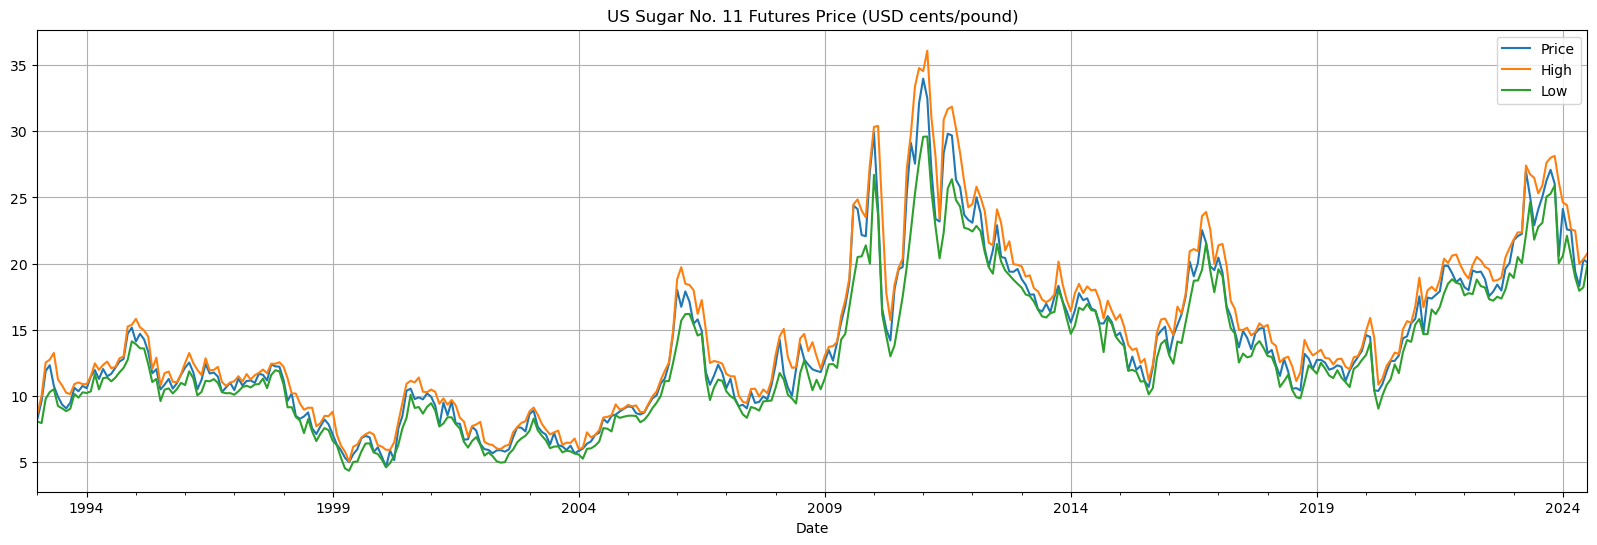

In [3]:
df_s11[['Price','High','Low']].plot(figsize=(20,6),grid=True,title='US Sugar No. 11 Futures Price (USD cents/pound)')

### Análisis de Auto-Correlación

Este análisis permite identificar correlaciones entre el valor actual de la serie con valores de la misma serie en el pasado (lags). En este caso, al ser la frecuencia mensual, se trata de identificar la correlación con meses anteriores. Esto permite identificar el orden del modelo de auto-regresión / media móvil a utilizar.

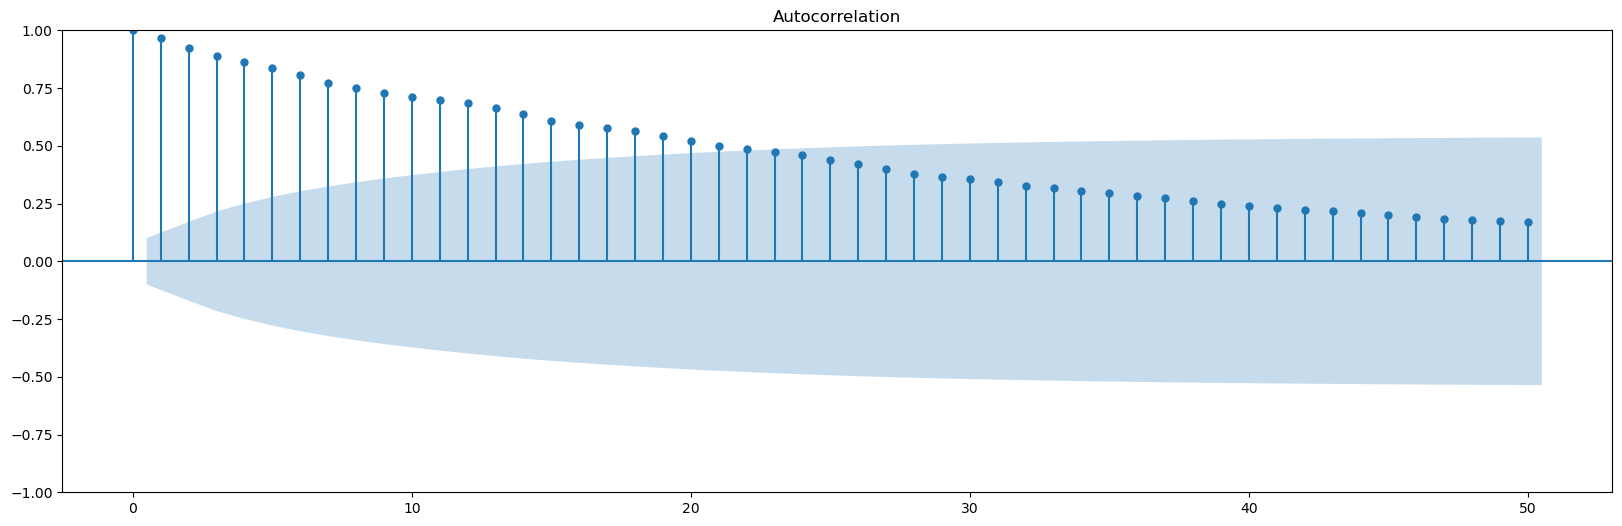

In [4]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(20, 6))
plot_acf(df_s11.Price, ax=ax, lags=50)
plt.show()

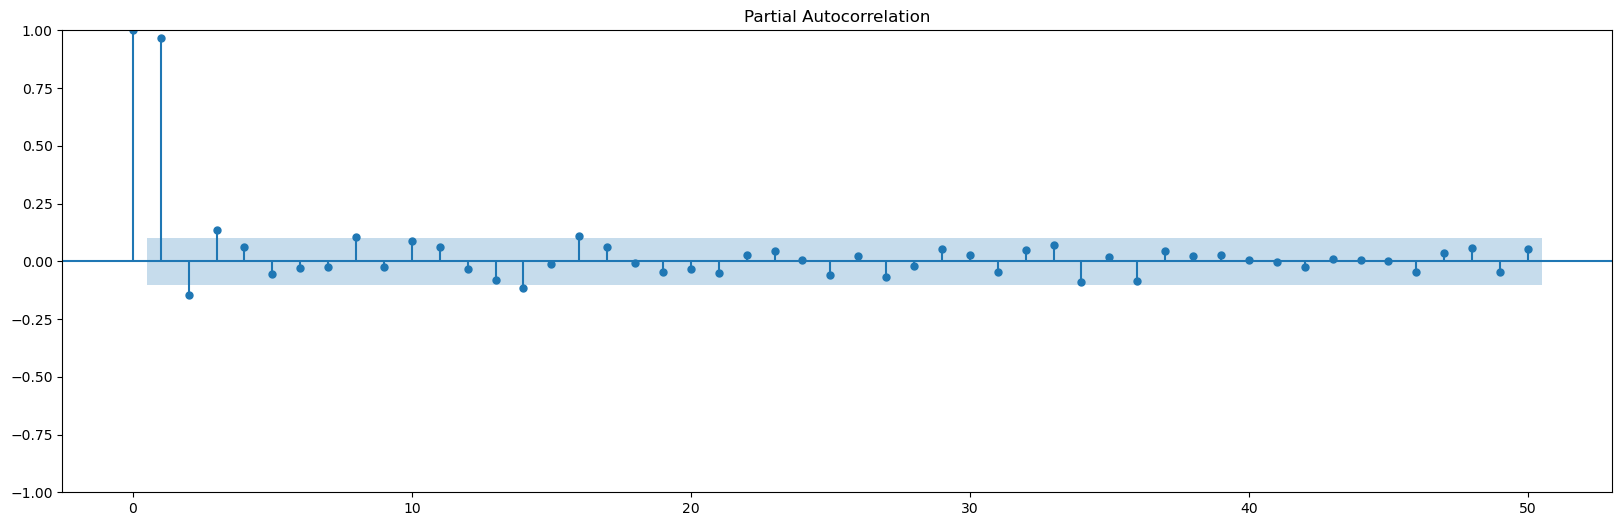

In [5]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(20,6))
plot_pacf(df_s11.Price, ax=ax, lags=50)
plt.show()

El análisis de **auto-correlacion** análisis muestra que existe el valor actual del precio tiene correlación significativa con los valores anteriores del precio hasta 21 atrás. Dado que esta relación es recursiva, el análisis de **auto-correlación parcial** aisla los efectos recursivos y muestra que, el valor actual del precio tiene una correlación significativa con los precios de los dos meses anteriores.

### Identificación de Estacionalidad
Se explora la posible estacionalidad de la serie temporal de precios, para observar si existe algún patrón mensual.

<Axes: title={'center': 'US Sugar Futures Contract No. 11 Price Monthly Distributions'}, xlabel='month', ylabel='Price'>

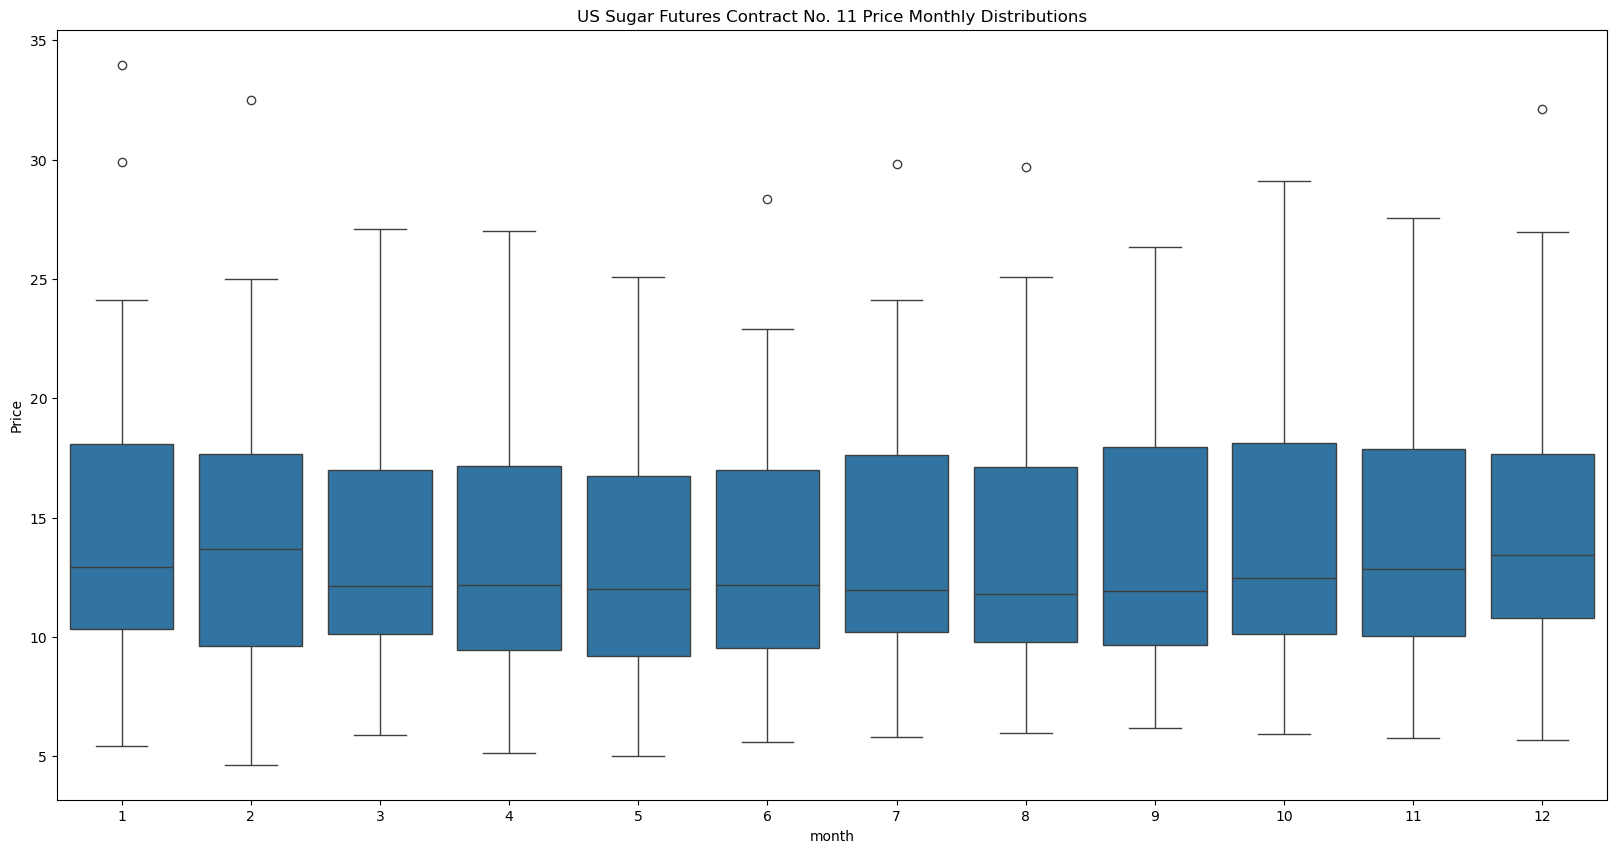

In [6]:
df_boxplot = df_s11
df_boxplot['month'] = df_boxplot.index.month
fig, ax = plt.subplots(figsize=(20,10))
plt.set_loglevel('WARNING')
df_boxplot = pd.DataFrame(df_s11.sort_values('month')['Price']).astype(float)
df_boxplot['month'] = df_boxplot.index.month
plt.title('US Sugar Futures Contract No. 11 Price Monthly Distributions')
df_boxplot
sns.boxplot(data=df_boxplot, x="month", y="Price")

Esto muestra que en general los precios no tienen una estacionalidad significativa. Puede sin embargo encontrarse que los precios al inicio y final del año tienden a ser un poco más elevados que en el resto del año.

### Auto-Regressor Forecaster

Para modelar esta serie temporal se utiliza un modelo de **pronóstico por auto-regresión multi-paso directa**. 

Es una regresión (algoritmo supervisado) en la que se utilizan valores pasados de la serie para pronosticar varios valores en el futuro de la misma. El número de valores futuros a pronosticar define cuántas instancias de regresión se entrenan, como se observa en la siguiente figura (tres pasos en el futuro en este ejemplo): 

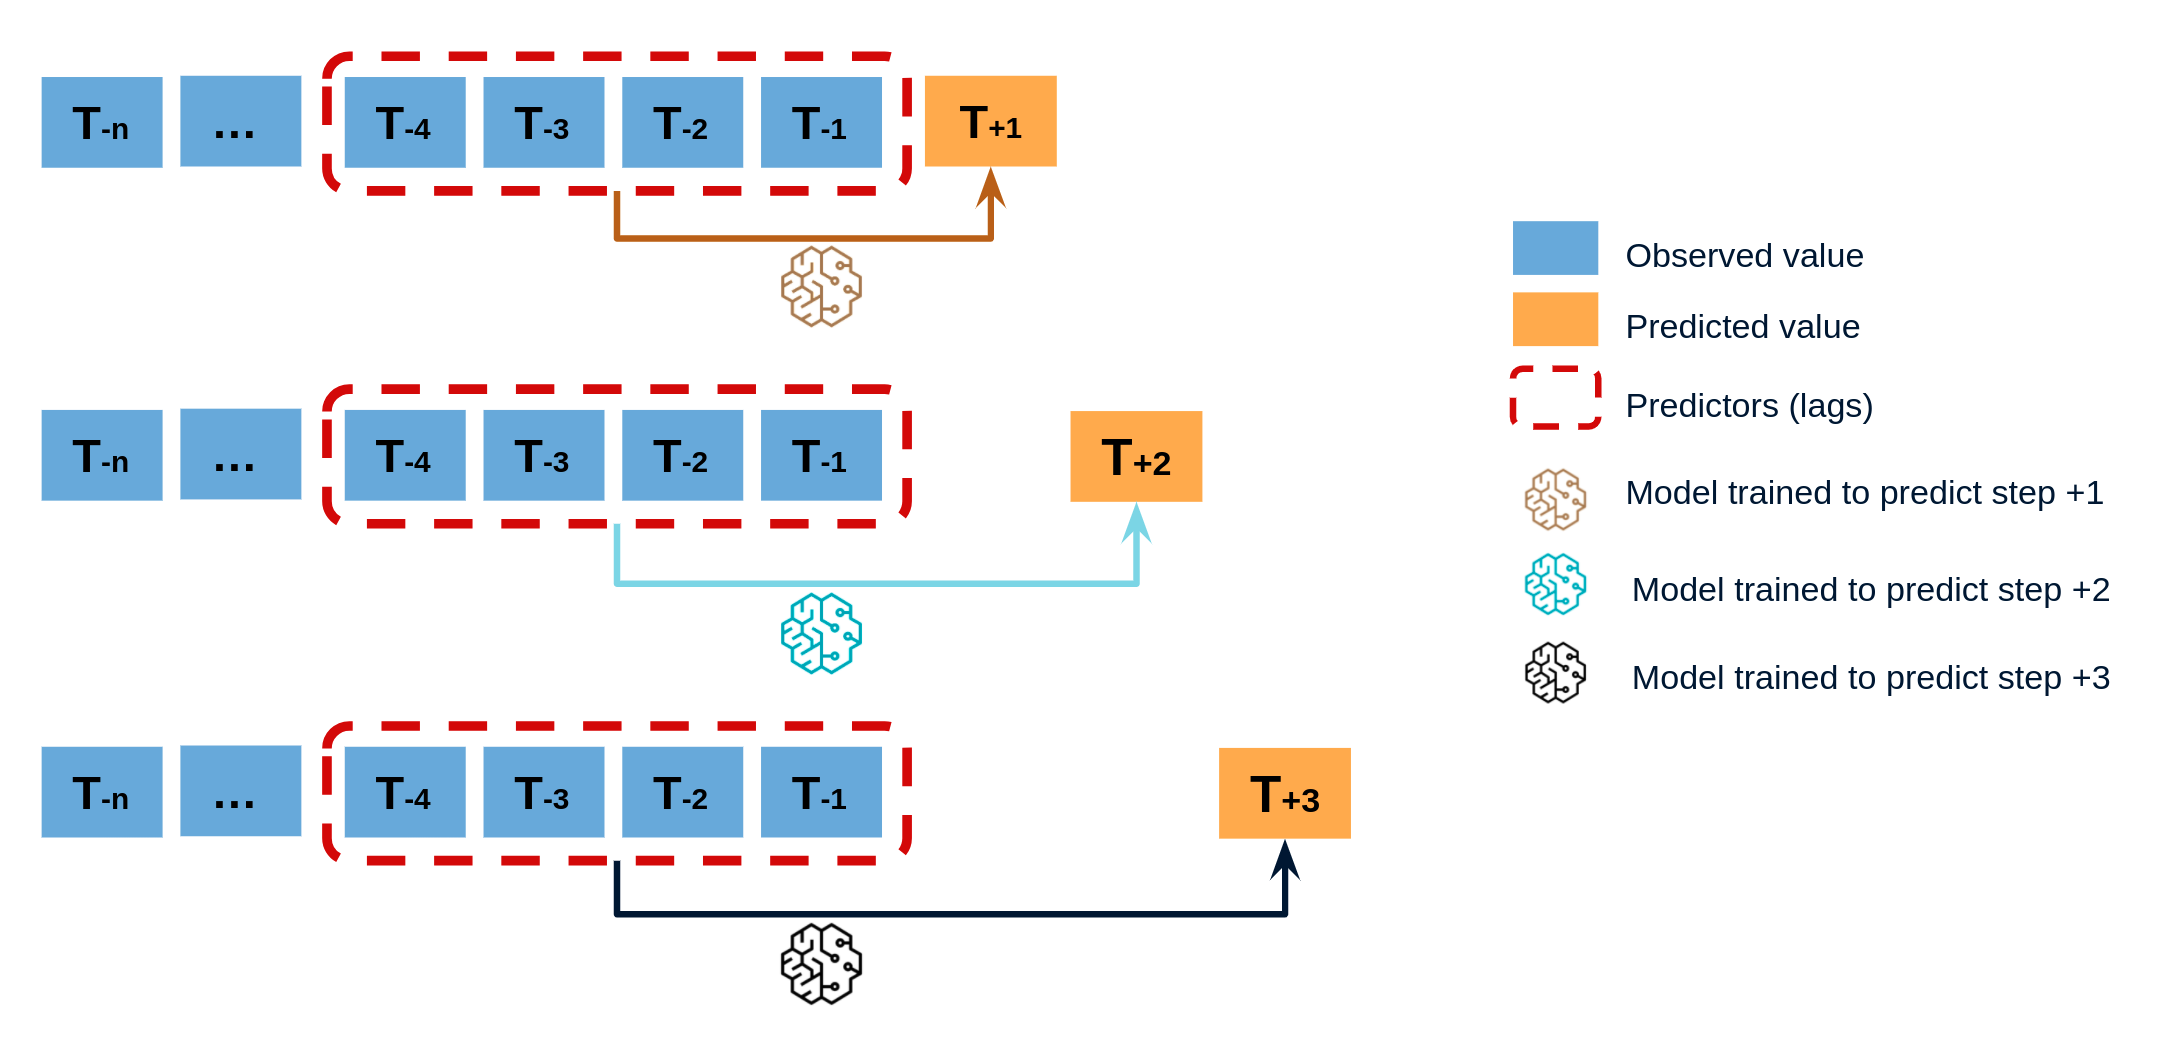

### Train - Val - Test Split
Se definen los conjuntos de entrenamiento, validación y test para verificación de métricas del modelo.
En este caso específico se cuenta con 379 observaciones (desde Enero 1993 a Julio 2024), por lo que se separan de la siguiente manera:

- Entrenamiento: 292 muestras mensuales (Enero 1993 - Abril 2017)
- Validación: 47 muestras mensuales (Abril 2017 - Marzo 2021)
- Test: 40 muestras mensuales (Abril 2021 - Julio 2024)

Para el entrenamiento se utiliza **grid-search** para encontrar hiper-parámetros óptimos para el algoritmo de regresión **Random Forest Regressor**.

Las combinaciones de hiper-parámetros que se definen con grid-search resulta en la exploración de **320 modelos** de los cuales se selecciona el mejor para hacer el entrenamiento final.

In [7]:
end_train = '2017-04-01 00:00:00'
end_val = '2021-03-01 00:00:00'

In [8]:
len(df_s11.loc[:'2017-04-01 00:00:00','Price'])

292

In [9]:
len(df_s11.loc[:'2021-03-01 00:00:00','Price'])

339

In [10]:
len(df_s11['Price'])

379

In [11]:
# Grid search hyperparameter and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=1234),
                lags      = 15 # Placeholder, the value will be overwritten
             )

# Lags used as predictors
lags_grid = [5, 10, 15,  20, 25]

# Regressor hyperparameters
param_grid = {'n_estimators': [5, 10, 20, 25], 'max_depth': [None,1,3,5, 10, 15,20,50], 'bootstrap': [True,False]} 

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = df_s11.loc[:end_val, 'Price'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 24,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = len(df_s11.loc[:end_train]),
                        #fixed_train_size   = False,
                        return_best = True,
                        verbose     = False
               )

Number of models compared: 320.


lags grid:   0%|          | 0/5 [00:00<?, ?it/s]

params grid:   0%|          | 0/64 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'bootstrap': False, 'max_depth': 50, 'n_estimators': 5}
  Backtesting metric: 4.566948255319149



### Backtesting

Se comparan los pronósticos con valores reales nunca antes vistos por el modelo.

In [12]:
# Train forecaster over training set
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=1234, bootstrap=False, max_depth=50, n_estimators=5),
                lags      = 10
             )
forecaster.fit(df_s11.loc[:end_train,'Price'])

In [13]:
# Backtesting
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = df_s11['Price'],
                            steps              = 24,
                            metric             = 'mean_absolute_error',
                            initial_train_size = len(df_s11.loc[:end_train]),
                            refit              = False,
                            n_jobs             = 'auto',
                            verbose            = True,
                            show_progress      = True
                        )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 292
Number of observations used for backtesting: 87
    Number of folds: 4
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 15 observations.

Fold: 0
    Training:   1993-01-01 00:00:00 -- 2017-04-01 00:00:00  (n=292)
    Validation: 2017-05-01 00:00:00 -- 2019-04-01 00:00:00  (n=24)
Fold: 1
    Training:   1993-01-01 00:00:00 -- 2017-04-01 00:00:00  (n=292)
    Validation: 2019-05-01 00:00:00 -- 2021-04-01 00:00:00  (n=24)
Fold: 2
    Training:   1993-01-01 00:00:00 -- 2017-04-01 00:00:00  (n=292)
    Validation: 2021-05-01 00:00:00 -- 2023-04-01 00:00:00  (n=24)
Fold: 3
    Training:   1993-01-01 00:00:00 -- 2017-04-01 00:00:00  (n=292)
    Validation: 2023-05-01 00:00:00 -- 2024-07-01 00:00:00  (n=15)



  0%|          | 0/4 [00:00<?, ?it/s]

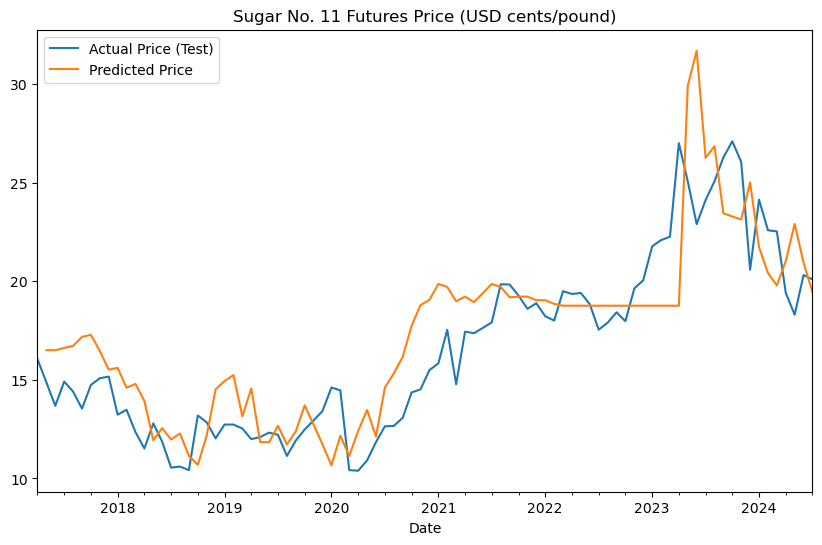

In [14]:
df_s11.loc[end_train:,'Price'].plot(figsize=(10,6))
predicciones['pred'].plot()
plt.title('Sugar No. 11 Futures Price (USD cents/pound)')
plt.legend(["Actual Price (Test)", "Predicted Price"]);

### Resultado Grid-Search

El mejor modelo es un modelo de **auto-regresión Random Forest** con los siguientes hiper-parámetros:

- Lags: [ 1  2  3  4  5  6  7  8  9 10] 
- Parametros: {'bootstrap': False, 'max_depth': 50, 'n_estimators': 5}
- Backtesting metric (Mean Squared Error): 4.566948255319149

En el análisis de backtest, el error medio es de **2.1 centavos/libra**.

### Entrenamiento 

In [15]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=1234, bootstrap=False, max_depth=50, n_estimators=5),
                lags      = 10 # Placeholder, the value will be overwritten
             )
forecaster.fit(df_s11['Price'])

### Pronóstico a 24 meses

In [16]:
predictions = pd.DataFrame(forecaster.predict(steps=24))
predictions.rename(columns={"pred": "Price"},inplace=True)
predictions= pd.concat([df_s11.tail(1)['Price'], predictions])
predictions.rename(columns={"Price": "Predictions"},inplace=True)

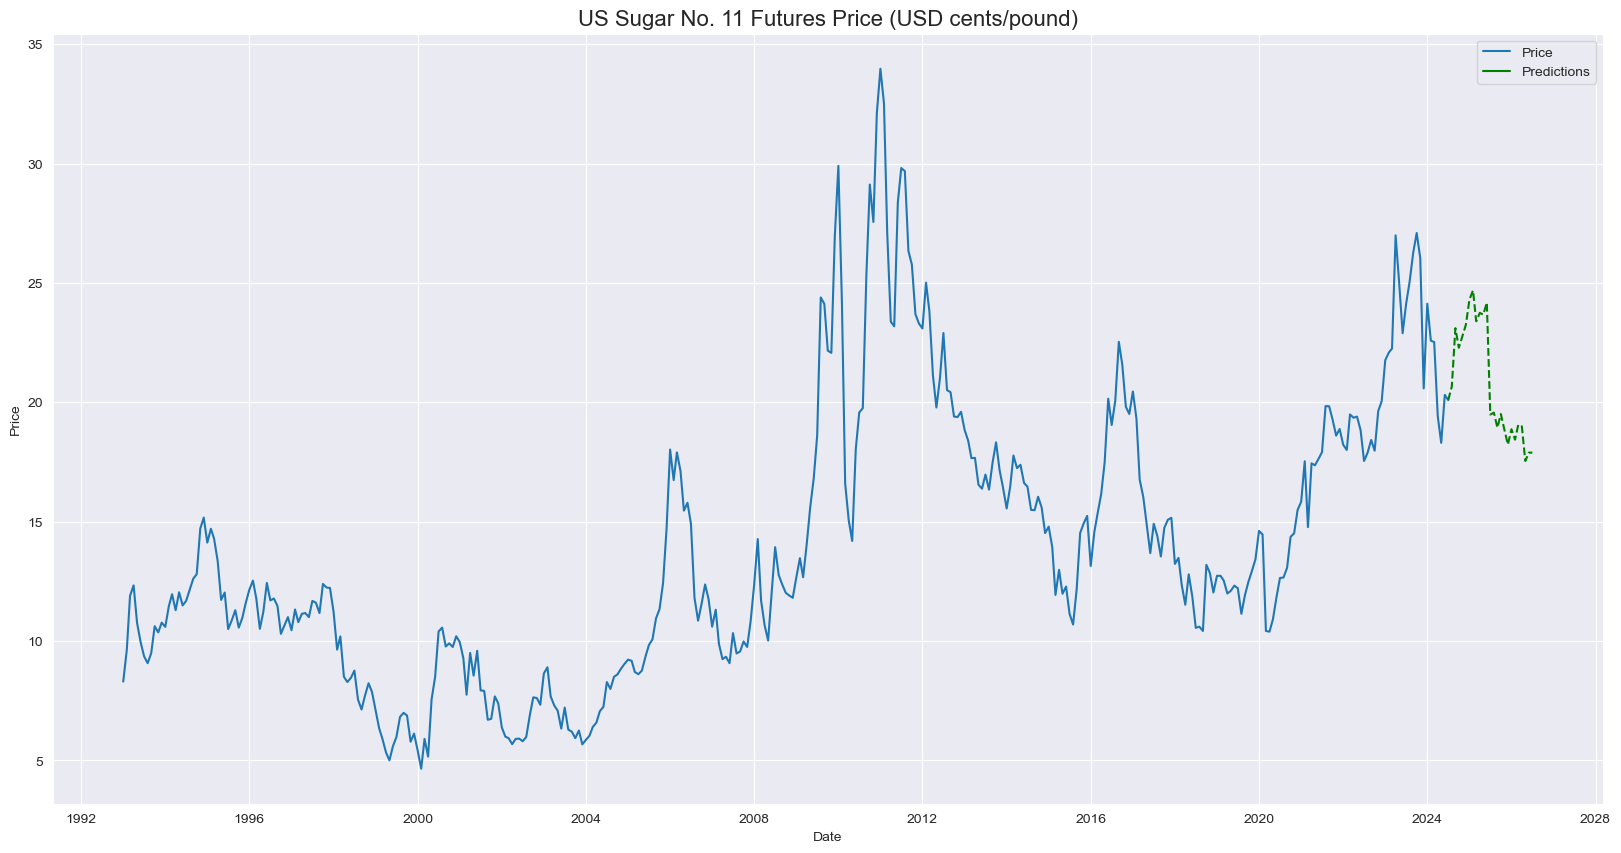

In [17]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=df_s11.loc[:, 'Price'],label='Price',ax=ax).set_title('US Sugar No. 11 Futures Price (USD cents/pound)',fontsize=16)
sns.lineplot(data=predictions,ax=ax,palette=['green'])
ax.lines[1].set_linestyle("--")

In [18]:
predictions

,Predictions
2024-07-01,20.090
2024-08-01,20.662
2024-09-01,23.102
2024-10-01,22.282
2024-11-01,22.770
2024-12-01,23.246
2025-01-01,24.298
2025-02-01,24.686
2025-03-01,23.390
2025-04-01,23.746
